# **1. Configuración del ambiente**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import zipfile
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import linear_kernel
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)


# **2. Obtención de datos**

In [ ]:
!curl http://files.grouplens.org/datasets/movielens/ml-latest-small.zip -o ml-latest-small.zip
with zipfile.ZipFile('ml-latest-small.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0  2272k      0 --:--:-- --:--:-- --:--:-- 2274k


In [ ]:
#Creamos una copia de los dataframes
df_movies = pd.read_csv('/content/data/ml-latest-small/movies.csv')
df_ratings = pd.read_csv('/content/data/ml-latest-small/ratings.csv')

In [ ]:
!curl http://files.grouplens.org/datasets/movielens/ml-latest-small.zip -o ml-latest-small.zip
with zipfile.ZipFile('ml-latest-small.zip', 'r') as zip_ref:
    zip_ref.extractall('data')
global df_movies_copy, df_ratings_copy, df_final

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0  2977k      0 --:--:-- --:--:-- --:--:-- 2975k


In [ ]:
df_movies.head(5)

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [ ]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [ ]:
df_movies.shape

(9742, 3)

In [ ]:
df_ratings.head(5)

userId  movieId  rating  timestamp
0       1        1    4.00  964982703
1       1        3    4.00  964981247
2       1        6    4.00  964982224
3       1       47    5.00  964983815
4       1       50    5.00  964982931

In [ ]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [ ]:
df_ratings.shape

(100836, 4)

In [ ]:
#Hacemos copia de los dataframes
df_movies_copy = df_movies.copy()
df_ratings_copy = df_ratings.copy()


# **3. Tratamiento de los datos**

## Datos nulos

In [ ]:
df_movies_copy.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [ ]:
df_ratings_copy.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [ ]:
df_movies_copy.shape

(9742, 3)

In [ ]:
df_movies_copy.dropna(inplace=True)
df_movies_copy.shape

(9742, 3)

In [ ]:
df_ratings_copy.shape

(100836, 4)

In [ ]:
df_ratings_copy.dropna(inplace=True)
df_ratings_copy.shape

(100836, 4)

In [ ]:
df_movies_copy.drop_duplicates(subset='movieId',keep='first', inplace=True)
df_movies_copy.shape

(9742, 3)

In [ ]:
df_ratings_copy.drop_duplicates(subset=['movieId','userId'],keep='first', inplace=True)
df_ratings_copy.shape

(100836, 4)

In [ ]:
df_movies_copy['content'] = df_movies_copy['genres'].str.replace('|', ' ')
df_movies_copy.head(5)

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  \
0  Adventure|Animation|Children|Comedy|Fantasy   
1                   Adventure|Children|Fantasy   
2                               Comedy|Romance   
3                         Comedy|Drama|Romance   
4                                       Comedy   

                                       content  
0  Adventure Animation Children Comedy Fantasy  
1                   Adventure Children Fantasy  
2                               Comedy Romance  
3                         Comedy Drama Romance  
4                                       Comedy

In [ ]:
df_movies_copy['genre_set'] = df_movies_copy['genres'].apply(lambda x: ', '.join(sorted(set(x.split('|')))))
df_movies_copy.head(5)

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  \
0  Adventure|Animation|Children|Comedy|Fantasy   
1                   Adventure|Children|Fantasy   
2                               Comedy|Romance   
3                         Comedy|Drama|Romance   
4                                       Comedy   

                                       content  \
0  Adventure Animation Children Comedy Fantasy   
1                   Adventure Children Fantasy   
2                               Comedy Romance   
3                         Comedy Drama Romance   
4                                       Comedy   

                                         genre_set  
0  Adventure, Animation, Children, Comedy, Fantasy  
1                     Adventure, Children, Fantasy  
2                                  Comedy, Romance  
3                           Comedy, Drama, Romance  
4                                           Comedy

In [ ]:
df_movies_copy.dtypes

movieId       int64
title        object
genres       object
content      object
genre_set    object
dtype: object

In [ ]:
df_ratings_copy.dtypes


userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

In [ ]:
df_ratings_copy['timestamp'] = pd.to_datetime(df_ratings_copy['timestamp'], unit='s').dt.normalize()
df_ratings_copy.head(5)

userId  movieId  rating  timestamp
0       1        1    4.00 2000-07-30
1       1        3    4.00 2000-07-30
2       1        6    4.00 2000-07-30
3       1       47    5.00 2000-07-30
4       1       50    5.00 2000-07-30

In [ ]:
df_ratings_copy.dtypes

userId                int64
movieId               int64
rating              float64
timestamp    datetime64[ns]
dtype: object

In [ ]:
def preprocesamiento():
    global df_movies_copy, df_ratings_copy
    df_movies_copy.dropna(inplace=True)
    df_ratings_copy.dropna(inplace=True)
    df_movies_copy.drop_duplicates(subset='movieId',keep='first', inplace=True)
    df_ratings_copy.drop_duplicates(subset=['movieId','userId'],keep='first', inplace=True)
    df_movies_copy['content'] = df_movies_copy['genres'].str.replace('|', ' ')
    df_movies_copy['genre_set'] = df_movies_copy['genres'].apply(lambda x: ', '.join(sorted(set(x.split('|')))))
    df_ratings_copy['timestamp'] = pd.to_datetime(df_ratings_copy['timestamp'], unit='s').dt.normalize()
    return df_movies_copy, df_ratings_copy

# **4. Análisis Exploratorio (EDA)**

In [ ]:
df_movies_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   movieId    9742 non-null   int64 
 1   title      9742 non-null   object
 2   genres     9742 non-null   object
 3   content    9742 non-null   object
 4   genre_set  9742 non-null   object
dtypes: int64(1), object(4)
memory usage: 380.7+ KB


In [ ]:
df_movies_copy.describe()

movieId
count   9742.00
mean   42200.35
std    52160.49
min        1.00
25%     3248.25
50%     7300.00
75%    76232.00
max   193609.00

In [ ]:
df_ratings_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userId     100836 non-null  int64         
 1   movieId    100836 non-null  int64         
 2   rating     100836 non-null  float64       
 3   timestamp  100836 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 3.1 MB


In [ ]:
df_ratings_copy.describe()

userId   movieId    rating                      timestamp
count 100836.00 100836.00 100836.00                         100836
mean     326.13  19435.30      3.50  2008-03-19 03:54:37.829346560
min        1.00      1.00      0.50            1996-03-29 00:00:00
25%      177.00   1199.00      3.00            2002-04-18 00:00:00
50%      325.00   2991.00      3.50            2007-08-02 00:00:00
75%      477.00   8122.00      4.00            2015-07-04 00:00:00
max      610.00 193609.00      5.00            2018-09-24 00:00:00
std      182.62  35530.99      1.04                            NaN

### Histograma de Ratings

Creamos un histograma para ver las distribución de las calificaciones que han dado los usuarios a las películas.

In [ ]:
# Vemos el total de calificaciones por cada puntuación
df_ratings_copy['rating'].value_counts()

rating
4.00    26818
3.00    20047
5.00    13211
3.50    13136
4.50     8551
2.00     7551
2.50     5550
1.00     2811
1.50     1791
0.50     1370
Name: count, dtype: int64

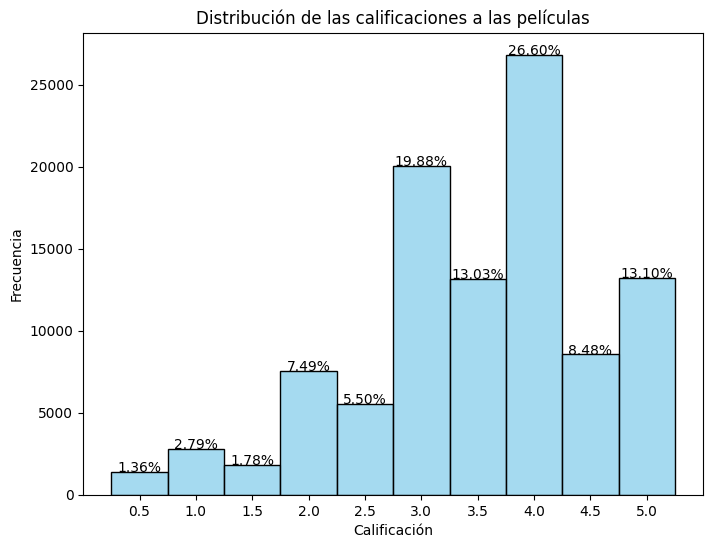

In [ ]:
plt.figure(figsize=(8, 6))
bin_edges = np.arange(0.25, 5.75, 0.5)
# Creamos el histograma
ax = sns.histplot(df_ratings_copy['rating'], bins=bin_edges, kde=False, color='skyblue', edgecolor='black')

# Calculamos el número total de calificaciones
total_ratings = df_ratings_copy['rating'].count()

# Agregamos el porcentaje a cada barra
for p in ax.patches:
    height = p.get_height()
    percentage = f'{(height / total_ratings) * 100:.2f}%'  # Calculate percentage
    ax.text(p.get_x() + p.get_width() / 2., height + 0.5, percentage, ha="center")

# Creamos las etiquetas para cada valor de calificación
ax.set_xticks(np.arange(0.5, 5.5, 0.5))

# Agregamos encabezados al titulo y a los ejes
plt.title('Distribución de las calificaciones a las películas')
plt.xlabel('Calificación')
plt.ylabel('Frecuencia')

# Show plot
plt.show()


###Histograma de calificaciones por año
Para entender como han calificado los usuarios a las películas a traves de los años , primero veremos las distribuciones totales de las calificaciones

Para entender mejor el histograma agruparemos las calificaciones entre 1 y 5 sin considerar los números flotantes

In [ ]:
# Creamos una función para categorizar
def categorizar_rating(rating):
    if rating <= 1.5:
        return 1
    elif rating <= 2.5:
        return 2
    elif rating <= 3.5:
        return 3
    elif rating <= 4.5:
        return 4
    else:
        return 5

In [ ]:
# Ahora lo aplicamos a la columna rating
df_ratings_copy['rating_categoria'] = df_ratings_copy['rating'].apply(categorizar_rating)
df_ratings_copy.head(5)

userId  movieId  rating  timestamp  rating_categoria
0       1        1    4.00 2000-07-30                 4
1       1        3    4.00 2000-07-30                 4
2       1        6    4.00 2000-07-30                 4
3       1       47    5.00 2000-07-30                 5
4       1       50    5.00 2000-07-30                 5

In [ ]:
df_ratings_copy['rating_categoria'].value_counts()

rating_categoria
4    35369
3    33183
5    13211
2    13101
1     5972
Name: count, dtype: int64

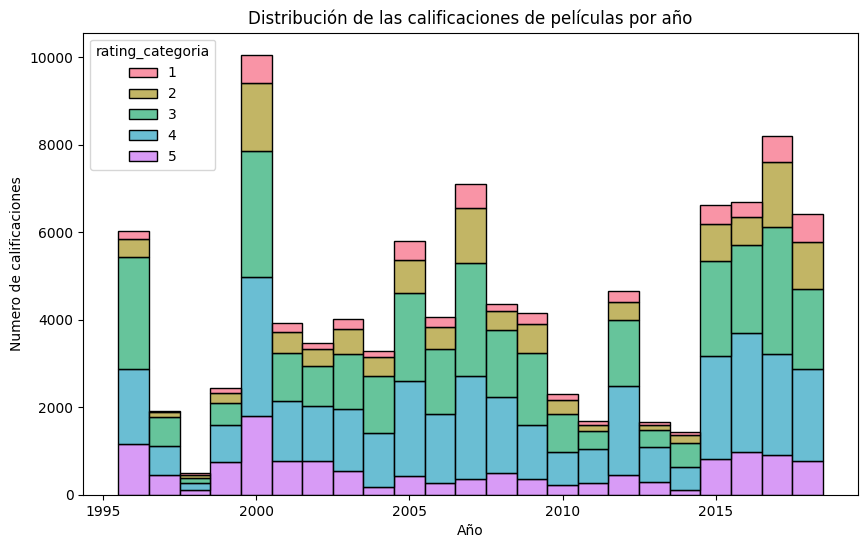

In [ ]:
# Extraemos el año desde la columna timestamp
df_ratings_copy['year'] = pd.to_datetime(df_ratings_copy['timestamp']).dt.year
# Elegimos el color de la paleta a usar
colors = sns.color_palette("husl", 5)
# Creamos el histograma
plt.figure(figsize=(10, 6))
sns.histplot(df_ratings_copy, x='year', hue='rating_categoria', multiple='stack', bins=20,palette=colors, discrete=True)
plt.title('Distribución de las calificaciones de películas por año')
plt.xlabel('Año')
plt.ylabel('Numero de calificaciones')
plt.show()

###Gráfico de barras de popularidad de generos basada en las calificaciones
Para mostrar la popularidad de cada genero entre los usuarios basado en el número de calificaciones.

<ipython-input-37-aceea5e5a28b>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, genre_counts[i] + 0.4, f'{genre_percentages[i]:.1f}%', ha='center')


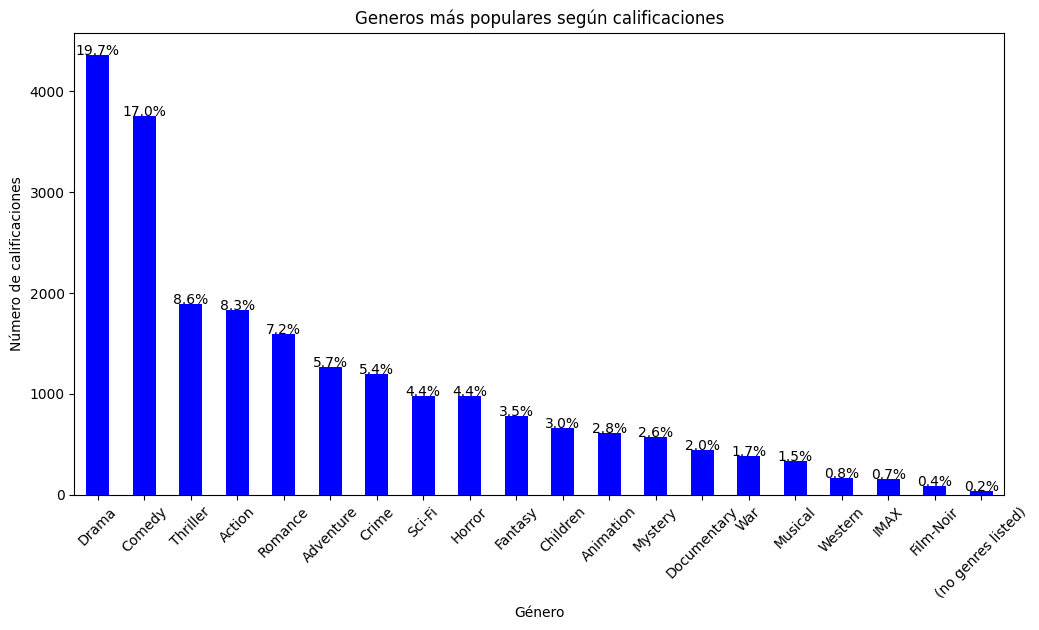

In [ ]:
genre_counts = df_movies_copy['genre_set'].str.get_dummies(', ').sum().sort_values(ascending=False)
total_ratings = genre_counts.sum()
genre_percentages = (genre_counts / total_ratings) * 100

# Create the bar plot
plt.figure(figsize=(12, 6))
ax = genre_counts.plot(kind='bar', color='blue')

# Annotate each bar with the percentage
for i in range(len(genre_counts)):
    plt.text(i, genre_counts[i] + 0.4, f'{genre_percentages[i]:.1f}%', ha='center')

# Title and labels
plt.title('Generos más populares según calificaciones')
plt.xlabel('Género')
plt.ylabel('Número de calificaciones')
plt.xticks(rotation=45)
plt.show()

###Creamos el df_final uniendo los dos datasets:


In [ ]:
df_final = pd.merge(df_ratings_copy, df_movies_copy, on='movieId')
df_final.head(5)

userId  movieId  rating  timestamp  rating_categoria  year  \
0       1        1    4.00 2000-07-30                 4  2000   
1       5        1    4.00 1996-11-08                 4  1996   
2       7        1    4.50 2005-01-25                 4  2005   
3      15        1    2.50 2017-11-13                 2  2017   
4      17        1    4.50 2011-05-18                 4  2011   

              title                                       genres  \
0  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
2  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
3  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
4  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   

                                       content  \
0  Adventure Animation Children Comedy Fantasy   
1  Adventure Animation Children Comedy Fantasy   
2  Adventure Animation Children Comedy Fantasy   
3  Adventure Animation Children Comedy Fantasy   
4  Adventure Animation Children Comedy Fantasy   

                                         genre_set  
0  Adventure, Animation, Children, Comedy, Fantasy  
1  Adventure, Animation, Children, Comedy, Fantasy  
2  Adventure, Animation, Children, Comedy, Fantasy  
3  Adventure, Animation, Children, Comedy, Fantasy  
4  Adventure, Animation, Children, Comedy, Fantasy

In [ ]:
df_final.drop(columns=['rating_categoria'], inplace=True)
df_final.head(5)

userId  movieId  rating  timestamp  year             title  \
0       1        1    4.00 2000-07-30  2000  Toy Story (1995)   
1       5        1    4.00 1996-11-08  1996  Toy Story (1995)   
2       7        1    4.50 2005-01-25  2005  Toy Story (1995)   
3      15        1    2.50 2017-11-13  2017  Toy Story (1995)   
4      17        1    4.50 2011-05-18  2011  Toy Story (1995)   

                                        genres  \
0  Adventure|Animation|Children|Comedy|Fantasy   
1  Adventure|Animation|Children|Comedy|Fantasy   
2  Adventure|Animation|Children|Comedy|Fantasy   
3  Adventure|Animation|Children|Comedy|Fantasy   
4  Adventure|Animation|Children|Comedy|Fantasy   

                                       content  \
0  Adventure Animation Children Comedy Fantasy   
1  Adventure Animation Children Comedy Fantasy   
2  Adventure Animation Children Comedy Fantasy   
3  Adventure Animation Children Comedy Fantasy   
4  Adventure Animation Children Comedy Fantasy   

                                         genre_set  
0  Adventure, Animation, Children, Comedy, Fantasy  
1  Adventure, Animation, Children, Comedy, Fantasy  
2  Adventure, Animation, Children, Comedy, Fantasy  
3  Adventure, Animation, Children, Comedy, Fantasy  
4  Adventure, Animation, Children, Comedy, Fantasy

In [ ]:
df_final.shape

(100836, 9)

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userId     100836 non-null  int64         
 1   movieId    100836 non-null  int64         
 2   rating     100836 non-null  float64       
 3   timestamp  100836 non-null  datetime64[ns]
 4   year       100836 non-null  int32         
 5   title      100836 non-null  object        
 6   genres     100836 non-null  object        
 7   content    100836 non-null  object        
 8   genre_set  100836 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(2), object(4)
memory usage: 6.5+ MB


# **5. Recomendación no personalizada**





### 5.1 Recomendación basada en filtrar las películas que tienen más de 210 votos

In [ ]:
def recomendaciones_populares(df):
  global df_movies_copy, df_ratings_copy, df_final
  count_rating = df.title.value_counts()
  popular_movie = count_rating[count_rating > 210].index
  df_popular_movies = df[df['title'].isin(popular_movie)]
  average_rating = df_popular_movies.groupby('title')['rating'].mean()
  df_movie_stats = pd.DataFrame({
        'mean_rating': average_rating,
        'vote_count': df_popular_movies['title'].value_counts(),
    })
  df_movie_stats_reset = df_movie_stats.reset_index()
  df_merged = pd.merge(df_popular_movies[['movieId', 'title']], df_movie_stats_reset, on='title', how='inner').drop_duplicates(subset=['title'])
  top_movies = df_merged.sort_values(by=['mean_rating'], ascending=False).head(10)
  print('Las 10 películas más populares son:  ')

  return top_movies

recomendaciones_populares(df_final)

Las 10 películas más populares son:  


movieId                                              title  mean_rating  \
2783      318                   Shawshank Redemption, The (1994)         4.43   
2565     2959                                  Fight Club (1999)         4.27   
452       260          Star Wars: Episode IV - A New Hope (1977)         4.23   
1577      527                            Schindler's List (1993)         4.22   
2076     1196  Star Wars: Episode V - The Empire Strikes Back...         4.22   
703       296                                Pulp Fiction (1994)         4.20   
2287     2571                                 Matrix, The (1999)         4.19   
1010      356                                Forrest Gump (1994)         4.16   
1797      593                   Silence of the Lambs, The (1991)         4.16   
215       110                                  Braveheart (1995)         4.03   

      vote_count  
2783         317  
2565         218  
452          251  
1577         220  
2076         211  
703          307  
2287         278  
1010         329  
1797         279  
215          237

### 5.2 Recomendación basada en una adaptación de una métrica estadística llamada promedio bayesiano.

In [ ]:
def recomendaciones_populares(df):
  global df_movies_copy, df_ratings_copy, df_final
  average_rating = df.groupby('title')['rating'].mean() # Promedio de calificación por película
  vote_count = df['title'].value_counts() # Número de votos por película
  C = df['rating'].mean()  # Media de las calificaciones global
  m = vote_count.quantile(0.90) # Número mínimo de votos por película,percentil 90
  # Fórmula del promedio bayesiano
  w1 = vote_count/(vote_count + m)
  w2 = m/(vote_count + m)
  bayesian_scores = ( w1 * average_rating) + (w2 * C)
  # Creamos el dataframe con las columnas
  df_movie_stats = pd.DataFrame({
        'mean_rating': average_rating,
        'vote_count': vote_count,
        'weighted_score': bayesian_scores
    })
  df_movie_stats_reset = df_movie_stats.reset_index()
  df_merged = pd.merge(df[['movieId', 'title']], df_movie_stats_reset, on='title', how='inner').drop_duplicates(subset=['title'])
  top_movies = df_merged.sort_values(by=['weighted_score'], ascending=False).head(10)

  print('Las 10 películas más populares son:  ')

  return top_movies

recomendaciones_populares(df_final)

Las 10 películas más populares son:  


movieId                                              title  \
16296      318                   Shawshank Redemption, The (1994)   
45361      858                              Godfather, The (1972)   
14323     2959                                  Fight Club (1999)   
1568       260          Star Wars: Episode IV - A New Hope (1977)   
572         50                         Usual Suspects, The (1995)   
3570       527                            Schindler's List (1993)   
1819       296                                Pulp Fiction (1994)   
6777      1196  Star Wars: Episode V - The Empire Strikes Back...   
12642     2571                                 Matrix, The (1999)   
50528     1221                     Godfather: Part II, The (1974)   

       mean_rating  vote_count  weighted_score  
16296         4.43         317            4.36  
45361         4.29         192            4.19  
14323         4.27         218            4.19  
1568          4.23         251            4.16  
572           4.24         204            4.15  
3570          4.22         220            4.15  
1819          4.20         307            4.14  
6777          4.22         211            4.13  
12642         4.19         278            4.13  
50528         4.26         129            4.13

# **6. Recomendación personalizada: Content-based**

### 6.1 Similitud de Coseno:




In [ ]:
df_movies_copy['content'].head(10)

0    Adventure Animation Children Comedy Fantasy
1                     Adventure Children Fantasy
2                                 Comedy Romance
3                           Comedy Drama Romance
4                                         Comedy
5                          Action Crime Thriller
6                                 Comedy Romance
7                             Adventure Children
8                                         Action
9                      Action Adventure Thriller
Name: content, dtype: object

In [ ]:
df_movies_copy['content'].tail(10)

9732     Action Animation Comedy Sci-Fi
9733                    Animation Drama
9734                       Comedy Drama
9735                          Animation
9736                        Documentary
9737    Action Animation Comedy Fantasy
9738           Animation Comedy Fantasy
9739                              Drama
9740                   Action Animation
9741                             Comedy
Name: content, dtype: object

In [ ]:
# Configurar el TfidfVectorizer con parámetros ajustados
tfidf_vectorizer = TfidfVectorizer(stop_words='english') #max_df=0.7, min_df=2)

# Calcular la matriz TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(df_movies_copy['content'])


In [ ]:
# Verificamos el tipo de dato de la matriz TF-IDF
type(tfidf_matrix)

scipy.sparse._csr.csr_matrix

In [ ]:
tfidf_matrix.shape

(9742, 23)

In [ ]:
# Calcular la matriz de similitud coseno
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
# Elaboramos una lista donde comparamos la película Toy Story(movieId=1)con el resto de películas y muestra la distancia con cada una
idx = 0  # índice de la película Toy Story
sim_scores = list(enumerate(cosine_sim[idx]))
# Ordenamos la lista poniendo la columna de distancia(x[1]) en orden descendente, la de mayor similitud primero
sim_scores.sort(key=lambda x: x[1], reverse=True)
# Elegimos los 10 primeros índices de la lista, quitando el O por que es la misma película
sim_scores = sim_scores[1:11]
sim_scores

[(1706, 0.9999999999999998),
 (2355, 0.9999999999999998),
 (2809, 0.9999999999999998),
 (3000, 0.9999999999999998),
 (3568, 0.9999999999999998),
 (6194, 0.9999999999999998),
 (6486, 0.9999999999999998),
 (6948, 0.9999999999999998),
 (7760, 0.9999999999999998),
 (8219, 0.9999999999999998)]

Para crear la función usaremos como parametros el índice que ordena secuencialmente todas las películas del dataframe *df_movie_copy* que también será un parametro, la matriz de similitud coseno y finalmente el número de recomendaciones (10) que daremos al usuario.

In [ ]:
def recomendacion_tf_idf(index,df,cosine_sim, n_recommendations=10):
    # Paso 1: Obtener el índice de la película
    idx = index

    # Paso 2: Obtener las puntuaciones de similitud coseno para todas las películas respecto a la película dada
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Paso 3: Ordenar las películas por las puntuaciones de similitud en orden descendente
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Paso 4: Filtrar o eliminar la película de entrada para que no se recomiende a sí misma
    sim_scores = sim_scores[1:]

    # Paso 5: Obtener los índices de las n_recommendations películas más similares
    movie_indices = [i[0] for i in sim_scores[:n_recommendations]]

    # Paso 6: Obtener los índices y las distancias de las películas recomendadas
    recommended_movies = df.iloc[movie_indices][['movieId', 'title','genres']]

    print('Si te gustó la película:  ')
    print(df[df.index == index]['title'].values[0])
    print('Te recomendamos las siguientes películas: ')

    # Retornar las películas recomendadas
    return recommended_movies


In [ ]:
recomendacion_tf_idf(4567,df_movies_copy,cosine_sim, n_recommendations=10)

Si te gustó la película:  
Kiss of the Spider Woman (1985)
Te recomendamos las siguientes películas: 


movieId                             title genres
25        26                    Othello (1995)  Drama
30        31            Dangerous Minds (1995)  Drama
36        40   Cry, the Beloved Country (1995)  Drama
39        43                Restoration (1995)  Drama
50        55                    Georgia (1995)  Drama
51        57      Home for the Holidays (1995)  Drama
55        62         Mr. Holland's Opus (1995)  Drama
105      121   Boys of St. Vincent, The (1992)  Drama
120      147    Basketball Diaries, The (1995)  Drama
121      148  Awfully Big Adventure, An (1995)  Drama

### 6.2 Similitud de Jaccard:

# **7. Recomendación personalizada: Collaborative Filtering**

### 7.1 Entrenar el Modelo KNN:

### Creamos una matriz a partir de df_ratings_copy

In [ ]:
#Creamos una matriz ratings_matrix con usuarios como filas y películas como columnas.
ratings_matrix = df_ratings_copy.pivot(index='userId', columns='movieId', values='rating')
ratings_matrix.head(5)



movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1          4.00     NaN    4.00     NaN     NaN    4.00     NaN     NaN   
2           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
5          4.00     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

movieId  9       10      11      12      13      14      15      16      \
userId                                                                    
1           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
5           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

movieId  17      18      19      20      21      22      23      24      \
userId                                                                    
1           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN     NaN     NaN     NaN    3.00     NaN     NaN     NaN   
5           NaN     NaN     NaN     NaN    4.00     NaN     NaN     NaN   

movieId  25      26      27      28      29      30      31      32      \
userId                                                                    
1           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN     NaN     NaN     NaN     NaN    0.50     NaN   
4           NaN     NaN     NaN     NaN     NaN     NaN     NaN    2.00   
5           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

movieId  34      36      38      39      40      41      42      43      \
userId                                                                    
1           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
5          4.00    4.00     NaN    3.00     NaN     NaN     NaN     NaN   

movieId  44      45      46      47      48      49      50      52      \
userId                                                                    
1           NaN     NaN     NaN    5.00     NaN     NaN    5.00     NaN   
2           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN    3.00     NaN    2.00     NaN     NaN     NaN    3.00   
5           NaN     NaN     NaN     NaN     NaN     NaN    4.00     NaN   

movieId  53      54      55      57      58      60      61      62      \
userId                                                                    
1           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN     NaN     NaN     NaN    3.00     NaN     NaN     NaN   
5           NaN     NaN     NaN     NaN    5.00     NaN     NaN     NaN   

movieId  63      64      65      66      68      69      70      71      \
userId                                                                    
1           NaN     NaN     NaN     NaN     NaN     NaN    3.00     NaN   
2           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN   

In [ ]:
ratings_matrix.shape#Muestra 610 filas(usuarios) y 9724 columnas(películas)

(610, 9724)

### Normalizamos la matriz creada
Calculamos avg_ratings como el promedio de calificaciones por usuario,para restarlo a cada calificación y normalizar las calificaciones a un valor cercano a cero, luego de eso, podemos llenar los valores NaN con cero, hay que recordar que en general los modelos de machine learning no trabajan con valores nulos ya que estos no les permiten hacer cálculos.

In [ ]:
#Calculamos avg_ratings como el promedio de calificaciones por usuario,sumamos todas las calificaciones y dividimos entre 9724(total películas)axis=1.
avg_ratings = ratings_matrix.mean(axis=1)
#Restamos el promedio a cada calificacion del usuario,axis=0. y luego llenamos los valores nulos con 0
ratings_matrix_normalized = ratings_matrix.sub(avg_ratings, axis=0).fillna(0)
ratings_matrix_normalized.head(5)

movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1         -0.37    0.00   -0.37    0.00    0.00   -0.37    0.00    0.00   
2          0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
3          0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
4          0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
5          0.36    0.00    0.00    0.00    0.00    0.00    0.00    0.00   

movieId  9       10      11      12      13      14      15      16      \
userId                                                                    
1          0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
2          0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
3          0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
4          0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
5          0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   

movieId  17      18      19      20      21      22      23      24      \
userId                                                                    
1          0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
2          0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
3          0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
4          0.00    0.00    0.00    0.00   -0.56    0.00    0.00    0.00   
5          0.00    0.00    0.00    0.00    0.36    0.00    0.00    0.00   

movieId  25      26      27      28      29      30      31      32      \
userId                                                                    
1          0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
2          0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
3          0.00    0.00    0.00    0.00    0.00    0.00   -1.94    0.00   
4          0.00    0.00    0.00    0.00    0.00    0.00    0.00   -1.56   
5          0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   

movieId  34      36      38      39      40      41      42      43      \
userId                                                                    
1          0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
2          0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
3          0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
4          0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
5          0.36    0.36    0.00   -0.64    0.00    0.00    0.00    0.00   

movieId  44      45      46      47      48      49      50      52      \
userId                                                                    
1          0.00    0.00    0.00    0.63    0.00    0.00    0.63    0.00   
2          0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
3          0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
4          0.00   -0.56    0.00   -1.56    0.00    0.00    0.00   -0.56   
5          0.00    0.00    0.00    0.00    0.00    0.00    0.36    0.00   

movieId  53      54      55      57      58      60      61      62      \
userId                                                                    
1          0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
2          0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
3          0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
4          0.00    0.00    0.00    0.00   -0.56    0.00    0.00    0.00   
5          0.00    0.00    0.00    0.00    1.36    0.00    0.00    0.00   

movieId  63      64      65      66      68      69      70      71      \
userId                                                                    
1          0.00    0.00    0.00    0.00    0.00    0.00   -1.37    0.00   
2          0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
3          0.00   

Este tipo de modelo KNN memoriza los valores que le vamos a pasar como entrenamiento y va a comparar la distancia entre usuario a través de la métrica coseno y comparandolo con un algoritmo bruto, asi este algoritmo creara una base de datos que te va indicar la distancia que hay entre cada usuario, y cuando le indiquemos algún usuario id nos va a indicar los usuarios mas parecidos en base a la distancia

In [ ]:
#Entrenamos el modelo knn_model usando ratings_matrix_normalized con similitud coseno.
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(ratings_matrix_normalized)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
ratings_matrix_normalized.shape#para hacer funcionar el algoritmo que vamos a crear debemos pasarle una matrix bidimensional igual a la principal

(610, 9724)

### Obtenemos los usuarios mas parecidos a un usuario dado

In [ ]:
#Obtenemos el índice en la matriz rating_matrix del userId 5 para ver cuales son sus vecinos mas cercanos, esto lo hacemos porque las matrices trabajan con el índice
idx = ratings_matrix.index.get_loc(5)
idx


4

In [ ]:
#Obtenemos todos los valores de la fila del índice dentro de la matriz normalizada rating_matrix_normalized
ratings_matrix_normalized.iloc[idx].values

array([0.36363636, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ])

In [ ]:
#Si hacemos un shape vemos que obtuvimos un vector unidimensional
ratings_matrix_normalized.iloc[idx].values.shape


(9724,)

In [ ]:
# Con la función reshape debemos convertirlo a bidimensional para que podamos obtener los resultados de la matriz normalizada que es bidimensional también
ratings_matrix_normalized.iloc[idx].values.reshape(1, -1)# aqui convertimos el vector en matriz bidimensional
ratings_matrix_normalized.iloc[idx].values.reshape(1, -1).shape #obtuvimos la fila del índice(1),hasta la última columna de la matriz(-1)

(1, 9724)

In [ ]:
distances, indices = knn_model.kneighbors(ratings_matrix_normalized.iloc[idx].values.reshape(1, -1), n_neighbors=4)
print(distances)
print(indices)


[[3.33066907e-16 6.25368717e-01 6.98744415e-01 7.47242965e-01]]
[[  4 144  34 564]]


In [ ]:
#Obtuvimos las distancias y los índices o vecinos mas cercanos pero aún en matriz bimensional
print(distances.shape)
print(indices.shape)

(1, 4)
(1, 4)


In [ ]:
#Con el método flatten() convertimos de nuevo a vectores unidimensionales las variables distance, indices y obtenemos los mas cercanos sin incluir el mismo índice
distances = distances.flatten()[1:]
indices = indices.flatten()[1:]
print(distances)
print(indices)


[0.62536872 0.69874442 0.74724296]
[144  34 564]


### Obtenemos las películas recomendadas según las preferidas por los usuarios parecidos al usuario al que recomendaremos

In [ ]:
# Creamos un dataframe solo con los usuarios parecidos
similar_users = ratings_matrix_normalized.iloc[indices]
similar_users.head(5)

movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
145        1.65    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
35         0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
565        0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   

movieId  9       10      11      12      13      14      15      16      \
userId                                                                    
145        0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
35         0.00    0.00   -0.09    0.00    0.00    0.00    0.00    0.00   
565        0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   

movieId  17      18      19      20      21      22      23      24      \
userId                                                                    
145        0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
35         0.00    0.00    0.00    0.00    0.91    0.00    0.00    0.00   
565        0.00    0.00   -0.66    0.00   -0.66    0.00    0.00    0.00   

movieId  25      26      27      28      29      30      31      32      \
userId                                                                    
145        0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
35         0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
565        0.00    0.00    0.00    0.00    0.00    0.00    0.00    1.34   

movieId  34      36      38      39      40      41      42      43      \
userId                                                                    
145        0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
35         0.00    0.00    0.00   -1.09    0.00    0.00    0.00    0.00   
565        0.34    0.00    0.00    0.00    0.00    0.00    0.00    0.00   

movieId  44      45      46      47      48      49      50      52      \
userId                                                                    
145        0.00    0.00    0.00    0.00    0.00    0.00    1.65    0.00   
35         0.00    0.00    0.00    0.00    0.00    0.00    0.91    0.00   
565        0.00    0.00    0.00    0.34    0.00    0.00    1.34    0.00   

movieId  53      54      55      57      58      60      61      62      \
userId                                                                    
145        0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
35         0.00    0.00    0.00    0.00    0.00    0.91    0.00    0.91   
565        0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   

movieId  63      64      65      66      68      69      70      71      \
userId                                                                    
145        0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
35         0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
565        0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   

movieId  72      73      74      75      76      77      78      79      \
userId                                                                    
145        0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
35         0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
565        0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   

movieId  80      81      82      83      85      86      87      88      \
userId                                                                    
145        0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
35         0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
565        0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   

movieId  89      92      93      94      95      96      97      99      \
userId                                                                    
145        0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
35         0.00

In [ ]:
#Hacemos una transpuesta al dataframe para luego agregar una columna de promedio de ratings
similar_users = similar_users.T
similar_users.head(5)

userId   145  35   565
movieId               
1       1.65 0.00 0.00
2       0.00 0.00 0.00
3       0.00 0.00 0.00
4       0.00 0.00 0.00
5       0.00 0.00 0.00

In [ ]:
#Calculamos el promedio con la formula: mean_rating= (calif_user1*distancia_user1)+(calif_user2*distancia_user2)+(calif_user3*distancia_user3)/distancia_user1+distancia_user2+distancia_user3
mean_ratings = similar_users.dot(distances)/np.sum(distances)
mean_ratings_df = pd.DataFrame(mean_ratings,index=ratings_matrix.columns, columns=['mean_rating'])
mean_ratings_df = mean_ratings_df.dropna()
mean_ratings_df.head(5)

mean_rating
movieId             
1               0.50
2               0.00
3               0.00
4               0.00
5               0.00

###   Creamos la función KNN

In [ ]:
def recomendación_knn(user_id,ratings_matrix, ratings_matrix_normalized, df_movies_copy, knn_model, n_recommendations=10):
  if isinstance(user_id, int) and user_id in ratings_matrix.index:
    idx = ratings_matrix.index.get_loc(user_id)
    #new_user_ratings = ratings_matrix_normalized.iloc[idx].values.reshape(1, -1)
    distances, indices = knn_model.kneighbors(ratings_matrix_normalized.iloc[idx].values.reshape(1, -1), n_neighbors=n_recommendations + 1)
    distances = distances.flatten()[1:]
    indices = indices.flatten()[1:]
    similar_users = ratings_matrix_normalized.iloc[indices]
    mean_ratings = similar_users.T.dot(distances) / np.sum(distances)
    mean_ratings_df = pd.DataFrame(mean_ratings, index=ratings_matrix.columns, columns=['mean_rating'])
    mean_ratings_df = mean_ratings_df.dropna()
    # Paso 6: Filtrar las películas que el usuario ya ha calificado
    user_rated_movies = ratings_matrix.iloc[idx].dropna().index


    mean_ratings_df = mean_ratings_df[~mean_ratings_df.index.isin(user_rated_movies)]

        # Paso 7: Ordenar por las calificaciones más altas
    mean_ratings_df = mean_ratings_df.sort_values(by='mean_rating', ascending=False)

        # Paso 8: Obtener las recomendaciones
    df_merged = pd.merge(df_movies_copy[['movieId', 'title', 'genres']], mean_ratings_df, left_on='movieId', right_index=True, how='inner')

        # Paso 9: Retornar las recomendaciones con las columnas solicitadas
    df_merged = df_merged[['movieId', 'title', 'genres', 'mean_rating']].sort_values(by='mean_rating', ascending=False).head(n_recommendations)

    return df_merged
  else:
    return f"El usuario con ID {user_id} no se encuentra en la matriz de calificaciones."






In [ ]:
recomendaciones = recomendación_knn(50, ratings_matrix, ratings_matrix_normalized, df_movies_copy, knn_model, 10)
recomendaciones


movieId                                              title  \
898      1196  Star Wars: Episode V - The Empire Strikes Back...   
224       260          Star Wars: Episode IV - A New Hope (1977)   
694       912                                  Casablanca (1942)   
920      1219                                      Psycho (1960)   
899      1197                         Princess Bride, The (1987)   
828      1089                              Reservoir Dogs (1992)   
2145     2858                             American Beauty (1999)   
922      1221                     Godfather: Part II, The (1974)   
883      1178                              Paths of Glory (1957)   
2259     2997                        Being John Malkovich (1999)   

                                       genres  mean_rating  
898                   Action|Adventure|Sci-Fi         1.12  
224                   Action|Adventure|Sci-Fi         0.82  
694                             Drama|Romance         0.74  
920                              Crime|Horror         0.70  
899   Action|Adventure|Comedy|Fantasy|Romance         0.68  
828                    Crime|Mystery|Thriller         0.66  
2145                            Drama|Romance         0.66  
922                               Crime|Drama         0.64  
883                                 Drama|War         0.63  
2259                     Comedy|Drama|Fantasy         0.62